# Black carbon scavenging by low-level Arctic clouds in Arctic clouds - code to process data and produce main figures in manuscript and SI
15 August 2023, Paul Zieger (paul.zieger@aces.su.se)

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
import pandas as pd
import glob2
import datetime
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats.mstats import gmean
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import uncertainties as unc
import uncertainties.unumpy as unp
from scipy.special import erf

In [2]:
# Load Ambient temperature data (from EBAS)
header_temp=['starttime','endtime','T','flag_T']
flist = glob2.glob("P:\\data\\NYA\\TemperatureNYA\\*.nas")
flist.sort()
Met = pd.DataFrame() 
for i, file in enumerate(flist):
         # print('Reading: ' + file)
         # get the year:
         df1 = pd.read_csv(file,skiprows=5,nrows=1,dtype='str')  
         x=str(df1.values)
         year_in=x[3:7]
         # read the file
         df1 = pd.read_csv(file,skiprows=54, names = header_temp, delimiter='\s+|\s+|\s+|\s+', encoding='utf8')      
         df1['time']=pd.to_datetime(year_in)+pd.to_timedelta(df1['starttime']+(df1['endtime']-df1['starttime'])/2,unit='D')
         df1.set_index('time', inplace=True)   
         Met = Met.append(df1)
Met['T'][Met['T']>100]=np.nan
print('Temperature data read in. ') 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


Temperature data read in. 


In [3]:
# Load FM-120 data from Makoto Koike 2.2.2022
header_FM120=['DOY','year','month','day','hour','minute','Ndat','Nc','CWC','ER']
flist = glob2.glob("P:\\data\\NYA\\FM120\\FM120_10min_for_SU_220202\\FM*.dat")
flist.sort()
FM120 = pd.DataFrame() 
for i, file in enumerate(flist):
         #print('Reading: ' + file)   
         df1 = pd.read_csv(file,skiprows=17, names = header_FM120,encoding='utf8')    
         df1['time']=pd.to_datetime(df1.iloc[:,1:6],format='%Y-%m-%d %H:%M')
         df1.set_index('time', inplace=True)   
         FM120 = FM120.append(df1)           
FM120.ER[FM120.ER==-999]=np.nan
FM120.CWC[FM120.CWC==-999]=np.nan
FM120.Nc[FM120.Nc==-999]=np.nan
print('FM120 data read in. ') 

FM120 data read in. 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
# Load MAAP-GCVI data (alternatively one can use the text-file)
path_in='C:\\Paul\\PSI\\geomon\\data\\NYA\\MAAP_2021\\'
outpath='C:\\Paul\\PSI\\geomon\\analysis\\NYA\\MAAP_2021\\review\\';
store = pd.HDFStore(path_in + 'MAAPetal.h5') # open file
store.keys() 
MAAP=store['/data']
MAAP['BC_tot']=MAAP['BC_tot'].round(decimals=2)
MAAP['visibility']=MAAP['visibility'].round(decimals=1)
MAAP['z']=MAAP['z'].round(decimals=5)

In [5]:
# Convert to nano gram and apply new MAC value
MAC_org=6.6 # original MAC value from MAAP in m2/g
MAC_new=10.6 # Ohata et al
MAAP['ABS_cvi'] = MAAP['BC_cvi'].multiply(MAC_org*1.05)
MAAP['ABS_tot'] = MAAP['BC_tot'].multiply(MAC_org*1.05)

In [6]:
# Average to hourly values
t_avrg='1H'
abs_coeff_nocloud=pd.DataFrame()

# no-cloud periods
abs_coeff_nocloud['CVI']=MAAP.ABS_cvi[(MAAP.flag=='good') & (MAAP.CVI_status=='off')& (MAAP.visibility>5000)].resample(t_avrg).mean()
abs_coeff_nocloud['CVI count']=MAAP.ABS_cvi[(MAAP.flag=='good') & (MAAP.CVI_status=='off')& (MAAP.visibility>5000)].resample(t_avrg).count()
abs_coeff_nocloud['tot']=MAAP.ABS_tot[(MAAP.flag=='good') & (MAAP.CVI_status=='off')& (MAAP.visibility>5000)].resample(t_avrg).mean()
abs_coeff_nocloud['tot count']=MAAP.ABS_tot[(MAAP.flag=='good') & (MAAP.CVI_status=='off')& (MAAP.visibility>5000)].resample(t_avrg).count()
abs_coeff_nocloud['month'] = abs_coeff_nocloud.index.month
abs_coeff_nocloud['CVI'][abs_coeff_nocloud['CVI count']<30]=np.nan
abs_coeff_nocloud['tot'][abs_coeff_nocloud['tot count']<30]=np.nan
abs_coeff_nocloud['eBC_CVI']=abs_coeff_nocloud['CVI'].multiply(1000/MAC_new)
abs_coeff_nocloud['eBC_tot']=abs_coeff_nocloud['tot'].multiply(1000/MAC_new)

# cloudy periods
abs_coeff_cloud=pd.DataFrame()
abs_coeff_cloud['CVI']=MAAP.ABS_cvi[(MAAP.flag=='good') & (MAAP.CVI_status=='on')& (MAAP.visibility<1000)].resample(t_avrg).mean()
abs_coeff_cloud['tot']=MAAP.ABS_tot[(MAAP.flag=='good') & (MAAP.CVI_status=='on')& (MAAP.visibility<1000)].resample(t_avrg).mean()
abs_coeff_cloud['CVI count']=MAAP.ABS_cvi[(MAAP.flag=='good') & (MAAP.CVI_status=='on')& (MAAP.visibility<1000)].resample(t_avrg).count()
abs_coeff_cloud['tot count']=MAAP.ABS_tot[(MAAP.flag=='good') & (MAAP.CVI_status=='on')& (MAAP.visibility<1000)].resample(t_avrg).count()
abs_coeff_cloud['z']=MAAP.z[(MAAP.flag=='good') & (MAAP.CVI_status=='on')& (MAAP.visibility<1000)].resample(t_avrg).mean()
abs_coeff_cloud['month'] = abs_coeff_cloud.index.month
abs_coeff_cloud['CVI'][abs_coeff_cloud['CVI count']<30]=np.nan
abs_coeff_cloud['tot'][abs_coeff_cloud['tot count']<30]=np.nan
abs_coeff_cloud['eBC_CVI']=abs_coeff_cloud['CVI'].multiply(1000/MAC_new)
abs_coeff_cloud['eBC_tot']=abs_coeff_cloud['tot'].multiply(1000/MAC_new)
abs_coeff_cloud['CWC']=FM120.CWC.resample(t_avrg).mean()
abs_coeff_cloud['T_amb']=Met['T'].resample(t_avrg).mean()
abs_coeff_cloud['vis']=MAAP.visibility[(MAAP.flag=='good') & (MAAP.CVI_status=='on')& (MAAP.visibility<1000)].resample(t_avrg).mean()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anacon

# Results and main figures

In [7]:
# Data below level of detection (LOD) according to Asmi et al.
print('Total:')
print(round(sum(abs_coeff_cloud.tot<0.012)/len(abs_coeff_cloud.tot) *100,2))
print('CVI:')
print(round(sum(abs_coeff_cloud.CVI<0.012)/len(abs_coeff_cloud.CVI) *100,2))
print('Number of in-cloud eBC data (in hours):')
print(np.count_nonzero(~np.isnan(abs_coeff_cloud.tot) & ~np.isnan(abs_coeff_cloud.CVI)))
print('Number of out-of-cloud eBC data (in hours):')
print(np.count_nonzero(~np.isnan(abs_coeff_nocloud.tot) & ~np.isnan(abs_coeff_nocloud.CVI)))

Total:
2.15
CVI:
4.19
Number of in-cloud eBC data (in hours):
2158
Number of out-of-cloud eBC data (in hours):
17842


In [8]:
# Calculate scavenging ratio
abs_coeff_cloud['Ratio']=(1/0.46)*abs_coeff_cloud['CVI']/abs_coeff_cloud['tot']
abs_coeff_cloud['Ratio'].replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)

In [9]:
# Define new dataframes for boxplots
df_CWC=abs_coeff_cloud[{'Ratio','CWC'}]
df_CWC.dropna(inplace=True)
df_CWC_T=abs_coeff_cloud[{'Ratio','CWC','T_amb'}]
df_CWC_T.dropna(inplace=True)
df_T=abs_coeff_cloud[{'Ratio','T_amb'}]
df_T.dropna(inplace=True)
df_z=abs_coeff_cloud[{'Ratio','z'}]
df_z.dropna(inplace=True)
df_eBC=abs_coeff_cloud[{'Ratio','eBC_tot'}]
df_eBC.dropna(inplace=True)
df_vis=abs_coeff_cloud[{'Ratio','vis'}]
df_vis.dropna(inplace=True)
df_ebC_2=abs_coeff_cloud[{'eBC_CVI','eBC_tot','Ratio','CWC'}]
df_ebC_2.dropna(inplace=True)
df_ebC_3=abs_coeff_cloud[{'eBC_tot','eBC_CVI','Ratio','CWC'}]
df_ebC_3.dropna(inplace=True)
df_CWC_vis=abs_coeff_cloud[{'eBC_CVI','eBC_tot','CWC','vis','month'}]
df_CWC_vis.dropna(inplace=True)
df_CWC_T_eBC=abs_coeff_cloud[{'Ratio','z','CWC','T_amb','eBC_tot'}]
df_CWC_T_eBC.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Pr

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


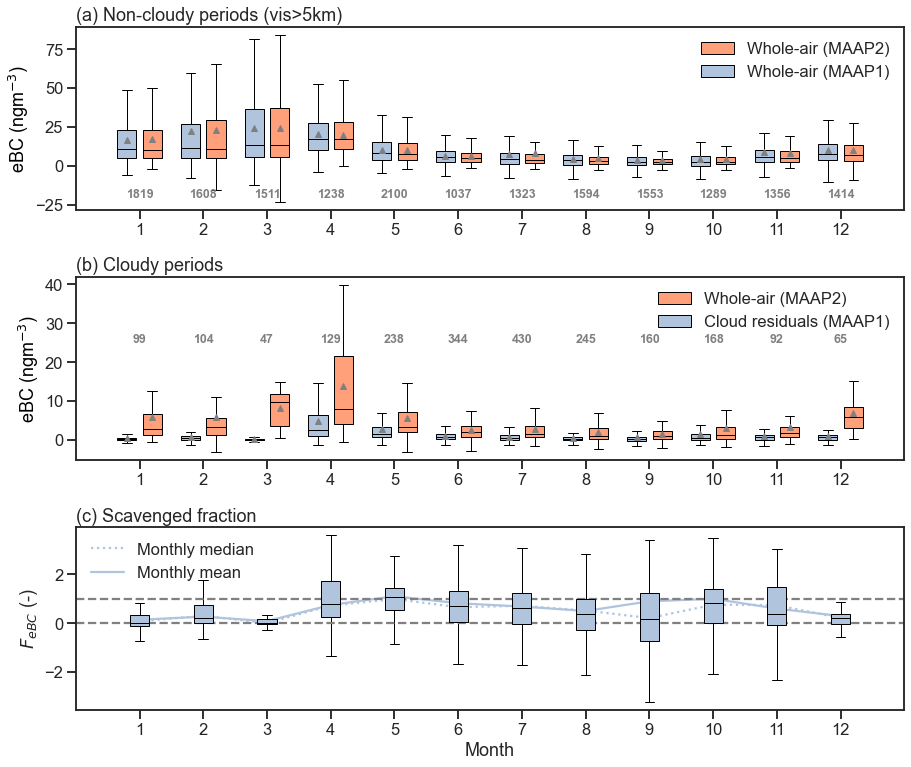

In [10]:
# Figure 1: Box plot of eBC in and outside clouds + scavenging ration
dum1=abs_coeff_cloud[{'eBC_CVI','eBC_tot','Ratio','month'}]
dum1.dropna(inplace=True)
dum2=abs_coeff_nocloud[{'eBC_CVI','eBC_tot','month'}]
dum2.dropna(inplace=True)

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

plt.figure(figsize=(13, 11))
ax=plt.subplot(3,1,1)
grouped_data_1 = dum2.eBC_CVI.groupby(dum2['month'])
grouped_data_2 = dum2.eBC_tot.groupby(dum2['month'])
bp1 = ax.boxplot([g for n,g in grouped_data_1], widths=0.3, positions=np.linspace(1,12,12)-0.2, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=True,
                meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
plt.setp(bp1["boxes"], facecolor='lightsteelblue')
bp2 = ax.boxplot([g for n,g in grouped_data_2], widths=0.3, positions=np.linspace(1,12,12)+0.2, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=True,
                meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
plt.setp(bp2["boxes"], facecolor='lightsalmon')
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(np.arange(1,13,1))
ax.legend([bp2["boxes"][0], bp1["boxes"][0]], ['Whole-air (MAAP2)', 'Whole-air (MAAP1)'], loc='upper right',
          frameon=False)
plt.xlim(0,13)
ax.set_ylabel('eBC (ngm$^{-3}$)', color='black')
plt.title('(a) Non-cloudy periods (vis>5km)', loc='left')

nobs=dum2.eBC_tot.groupby(dum2['month']).count()
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick]+1,
            -20,
            nobs.iloc[tick],
            horizontalalignment='center',
            size='x-small',
            color='grey',
            weight='semibold')


ax=plt.subplot(3,1,2)
grouped_data_1 = dum1.eBC_CVI.groupby(dum1['month'])
grouped_data_2 = dum1.eBC_tot.groupby(dum1['month'])
bp1 = ax.boxplot([g for n,g in grouped_data_1], widths=0.3, positions=np.linspace(1,12,12)-0.2, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=True, 
                meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
plt.setp(bp1["boxes"], facecolor='lightsteelblue')
bp2 = ax.boxplot([g for n,g in grouped_data_2], widths=0.3, positions=np.linspace(1,12,12)+0.2, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=True,
                 meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
plt.setp(bp2["boxes"], facecolor='lightsalmon')
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(np.arange(1,13,1))
plt.xlim(0,13)
ax.set_ylabel('eBC (ngm$^{-3}$)', color='black')
plt.title('(b) Cloudy periods', loc='left')

nobs=dum1.Ratio.groupby(dum1['month']).count()
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick]+1,
            25,
            nobs.iloc[tick],
            horizontalalignment='center',
            size='x-small',
            color='grey',
            weight='semibold')
ax.legend([bp2["boxes"][0], bp1["boxes"][0]], ['Whole-air (MAAP2)', 'Cloud residuals (MAAP1)'], 
          loc='best',frameon=False)    

ax=plt.subplot(3,1,3)
grouped_data_1 = dum1.Ratio.groupby(dum1['month'])
bp1 = ax.boxplot([g for n,g in grouped_data_1], widths=0.3, positions=np.linspace(1,12,12), showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'})
plt.setp(bp1["boxes"], facecolor='lightsteelblue')
BC_frac_med=(1/0.46)*abs_coeff_cloud.CVI.groupby(abs_coeff_cloud['month']).median().multiply(1000/MAC_new)/abs_coeff_cloud.tot.groupby(abs_coeff_cloud['month']).median().multiply(1000/MAC_new)
BC_frac_mean=(1/0.46)*abs_coeff_cloud.CVI.groupby(abs_coeff_cloud['month']).mean().multiply(1000/MAC_new)/abs_coeff_cloud.tot.groupby(abs_coeff_cloud['month']).mean().multiply(1000/MAC_new)
plt.plot(BC_frac_med,':',color='lightsteelblue',label='Monthly median')
plt.plot(BC_frac_mean,'-',color='lightsteelblue',label='Monthly mean')
plt.tight_layout()
ax.set_xticks(range(1, 13))
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('Month')
plt.legend(frameon=False, loc='upper left')
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(np.arange(1,13,1))
ax.set_xlabel('Month')
plt.plot([0,1000],[1,1],'--',color='grey')
plt.plot([0,1000],[0,0],'--',color='grey')
plt.xlim(0,13)
plt.title('(c) Scavenged fraction', loc='left')
plt.ylabel('$F_{eBC}$ (-)')

plt.tight_layout()

In [11]:
# Define functions for fits
def func(x, p0, p1, p2):
    return p0+ p1* np.exp(p2*x)

def func3(x, p0, p1, p2):
    return p0/(1+np.exp(p1*(x+p2)))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in log10


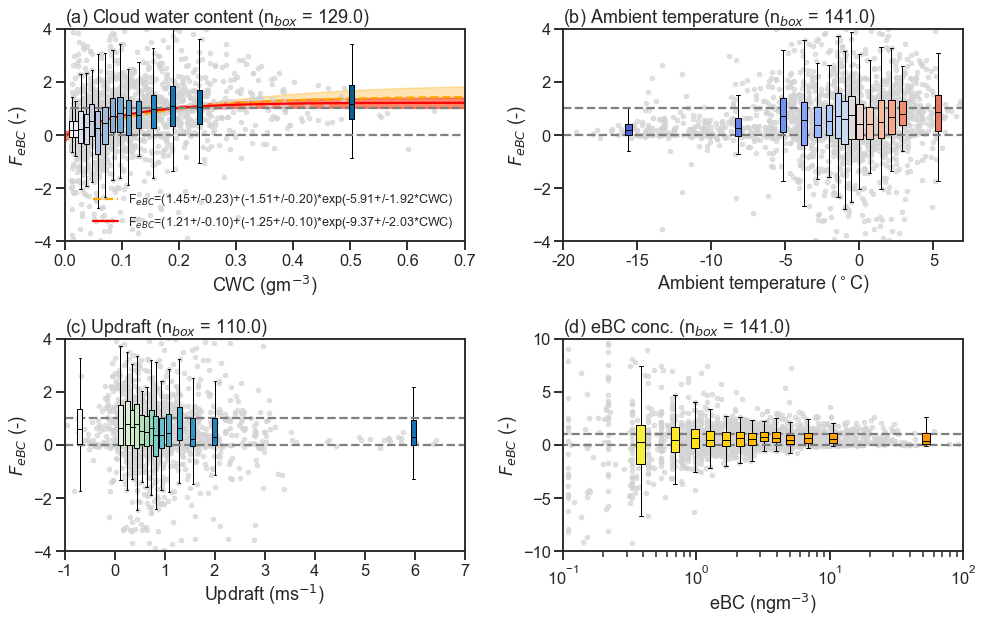

In [12]:
# Figure 2: Plot for bin by CWC, temperature, updraft, eBC
no_of_bins=15

FeBC_min=-5
FeBC_max=5

plt.figure(figsize=(14, 9))

px = np.linspace(0, 1, 100)

ax=plt.subplot(2,2,1)
# first the raw data
plt.plot(df_CWC.CWC[(df_CWC.Ratio>FeBC_min) & (df_CWC.Ratio<FeBC_max)],df_CWC.Ratio[(df_CWC.Ratio>FeBC_min) & (df_CWC.Ratio<FeBC_max)],'.',color='lightgrey', alpha=0.7)
popt, pcov = curve_fit(func, df_CWC.CWC[(df_CWC.Ratio>FeBC_min) & (df_CWC.Ratio<FeBC_max)].values,df_CWC.Ratio[(df_CWC.Ratio>FeBC_min) & (df_CWC.Ratio<FeBC_max)].values, [0.7, -0.55,-5.29], maxfev=5000)
a1, b1, c1 = unc.correlated_values(popt, pcov)
dum2=(('F$_{eBC}$=('+'{:10.2f}'.format(a1) +') + ' + '('+'{:10.2f}'.format(b1) +') * exp(' +'{:10.2f}'.format(c1) +' * CWC)'))
py = a1 + b1* unp.exp(c1 * px)
nom = unp.nominal_values(py)
std = unp.std_devs(py)
plt.fill_between(px,nom  -2 * std, nom +2 * std, color='orange',alpha=0.3)
plt.plot(px,func(px,*popt),'--',color='orange',label=dum2.replace(" ",""))
z_binned, bins = pd.qcut(df_CWC['CWC'],no_of_bins,retbins=True, precision=0)
grouped_N_all = df_CWC['Ratio'].groupby(z_binned)
palette = sns.color_palette('PuBu', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
z_binned.cat.rename_categories(mid)
bp1 = ax.boxplot([g for n,g in grouped_N_all], widths=0.009, positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=False)
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-0.1, 1, step=0.1))
ax.set_xticklabels(np.round(np.arange(-0.1, 1, step=0.1),2))
ax.set_xlim(0,0.7)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
nobs=df_CWC['Ratio'].groupby(z_binned).count()
popt, pcov = curve_fit(func, mid,df_CWC['Ratio'].groupby(z_binned).median().values, [0.7, -0.55,-5.29], maxfev=5000)
a2, b2, c2 = unc.correlated_values(popt, pcov)
dum1=(('F$_{eBC}$=('+'{:10.2f}'.format(a2) +') + ' + '('+'{:10.2f}'.format(b2) +') * exp(' +'{:10.2f}'.format(c2) +' * CWC)'))
py = a2 + b2* unp.exp(c2 * px)
nom = unp.nominal_values(py)
std = unp.std_devs(py)
plt.fill_between(px,nom  -2 * std, nom +2 * std, color='red',alpha=0.4)
plt.plot(px,func(px,*popt),'-',color='red',label=dum1.replace(" ","") )
plt.ylim(-4,4)
plt.legend(fontsize=12.5, frameon=False)
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('CWC (gm$^{-3}$)') 
plt.plot([-1,7],[1,1],'--k',color='grey')
plt.plot([-1,7],[0,0],'--k',color='grey')
plt.title('(a) Cloud water content (n$_{box}$ = ' + str(grouped_N_all.count().mean().round()) + ')' , loc='left')

# temperature data
ax=plt.subplot(2,2,2)
plt.plot(df_T.T_amb[(df_T.Ratio>FeBC_min) & (df_T.Ratio<FeBC_max)],df_T.Ratio[(df_T.Ratio>FeBC_min) & (df_T.Ratio<FeBC_max)],'.',color='lightgrey', alpha=0.7)
T_binned, bins = pd.qcut(df_T['T_amb'],no_of_bins,retbins=True)
palette = sns.color_palette('coolwarm', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
grouped_N = df_T['Ratio'].groupby(T_binned)
bp1 = ax.boxplot([g for n,g in grouped_N], widths=0.45, positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'})
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-20, 10, step=5))
ax.set_xticklabels(np.round(np.arange(-20, 10, step=5),2))
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('Ambient temperature ($^\circ$C)')
plt.ylim(-4,4)
plt.plot([-20,7],[1,1],'--k',color='grey')
plt.plot([-20,7],[0,0],'--k',color='grey')
plt.xlim(-20,7)
plt.title('(b) Ambient temperature (n$_{box}$ = ' + str(grouped_N.count().mean().round()) + ')', loc='left')

# updraft
ax=plt.subplot(2,2,3)
plt.plot(df_z.z[(df_z.Ratio>FeBC_min) & (df_z.Ratio<FeBC_max)],df_z.Ratio[(df_z.Ratio>FeBC_min) & (df_z.Ratio<FeBC_max)],'.',color='lightgrey', alpha=0.7)
z_binned, bins = pd.qcut(df_z['z'],no_of_bins,retbins=True,precision=0)
palette = sns.color_palette('GnBu', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
grouped_N = df_z['Ratio'].groupby(z_binned)
bp1 = ax.boxplot([g for n,g in grouped_N], widths=0.1, positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'})
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-1, 8, step=1))
ax.set_xticklabels(np.round(np.arange(-1, 8, step=1),2))    
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('Updraft (ms$^{-1}$)')
plt.ylim(-4,4)
plt.plot([-1,7],[1,1],'--k',color='grey')
plt.plot([-1,7],[0,0],'--k',color='grey')
plt.xlim(-1,7)
plt.title('(c) Updraft (n$_{box}$ = ' + str(grouped_N.count().mean().round()) + ')', loc='left')

# eBC concentration
ax=plt.subplot(2,2,4)
plt.plot(df_eBC.eBC_tot[(df_eBC.Ratio>-10) & (df_eBC.Ratio<10)],df_eBC.Ratio[(df_eBC.Ratio>-10) & (df_eBC.Ratio<10)],'.',color='lightgrey', alpha=0.7)
BC_binned, bins = pd.qcut(df_eBC['eBC_tot'],no_of_bins,retbins=True,precision=0,duplicates='drop')
palette = sns.color_palette('Wistia', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
grouped_N = df_eBC['Ratio'].groupby(BC_binned)
w = 0.06
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
bp1 = ax.boxplot([g for n,g in grouped_N], widths=width(mid,w), positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'})
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-0.01, 20, step=0.1))
ax.set_xticklabels(np.round(np.arange(-0.01, 20, step=0.1),2))       
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('eBC (ngm$^{-3}$)')
plt.ylim(-10,10)
plt.plot([0,100],[1,1],'--k',color='grey')
plt.plot([0,100],[0,0],'--k',color='grey')
plt.xlim(0.1,100)
plt.xscale('log')
plt.title('(d) eBC conc. (n$_{box}$ = ' + str(grouped_N.count().mean().round()) + ')', loc='left')
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
No handles with labels found to put in legend.


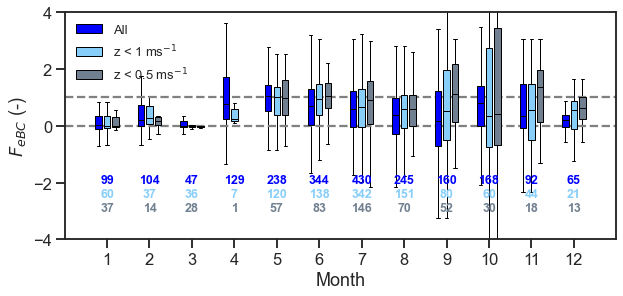

In [13]:
# Figure S4: The annual cycle of the scavenged fraction of eBC

dum1=abs_coeff_cloud[{'eBC_CVI','eBC_tot','Ratio','month','z'}]
dum1.dropna(inplace=True)

dum2=abs_coeff_cloud[{'eBC_CVI','eBC_tot','Ratio','month'}]
dum2.dropna(inplace=True)

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

plt.figure(figsize=(9, 12))

ax=plt.subplot(3,1,1)
grouped_data_1 = dum2.Ratio.groupby(dum2['month'])
bp1 = ax.boxplot([g for n,g in grouped_data_1], widths=0.15, positions=np.linspace(0.8,11.8,12), showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'})
plt.setp(bp1["boxes"], facecolor='blue')

grouped_data_1 = dum1[dum1.z<1].Ratio.groupby(dum1['month'])
bp2 = ax.boxplot([g for n,g in grouped_data_1], widths=0.15, positions=np.linspace(1,12,12), showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'})
plt.setp(bp2["boxes"], facecolor='lightskyblue')
grouped_data_1 = dum1[dum1.z<0.5].Ratio.groupby(dum1['month'])
bp3 = ax.boxplot([g for n,g in grouped_data_1], widths=0.15, positions=np.linspace(1.2,12.2,12), showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'})
plt.setp(bp3["boxes"], facecolor='slategrey')
plt.tight_layout()
ax.set_xticks(range(1, 13))
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('Month')
plt.legend(frameon=False, loc='upper left',fontsize=13)
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(np.arange(1,13,1))
ax.set_xlabel('Month')
plt.plot([0,1000],[1,1],'--',color='grey')
plt.plot([0,1000],[0,0],'--',color='grey')
plt.ylim(-4,4)
plt.xlim(0,13)
plt.ylabel('$F_{eBC}$ (-)')
nobs=dum1[dum1.z<1].Ratio.groupby(dum1['month']).count()
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick]+1,
            -2.5,
            nobs.iloc[tick],
            horizontalalignment='center',
            size='x-small',
            color='lightskyblue',
            weight='semibold')    
nobs=dum1[dum1.z<0.5].Ratio.groupby(dum1['month']).count()
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick]+1,
            -3,
            nobs.iloc[tick],
            horizontalalignment='center',
            size='x-small',
            color='slategrey',
            weight='semibold')
nobs=dum2.Ratio.groupby(dum2['month']).count()
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick]+1,
            -2,
            nobs.iloc[tick],
            horizontalalignment='center',
            size='x-small',
            color='blue',
            weight='semibold')
plt.legend([bp1["boxes"][0],bp2["boxes"][0], bp3["boxes"][0]],['All', 'z < 1 ms$^{-1}$','z < 0.5 ms$^{-1}$'],loc='upper left',frameon=False,fontsize=13)
plt.tight_layout()

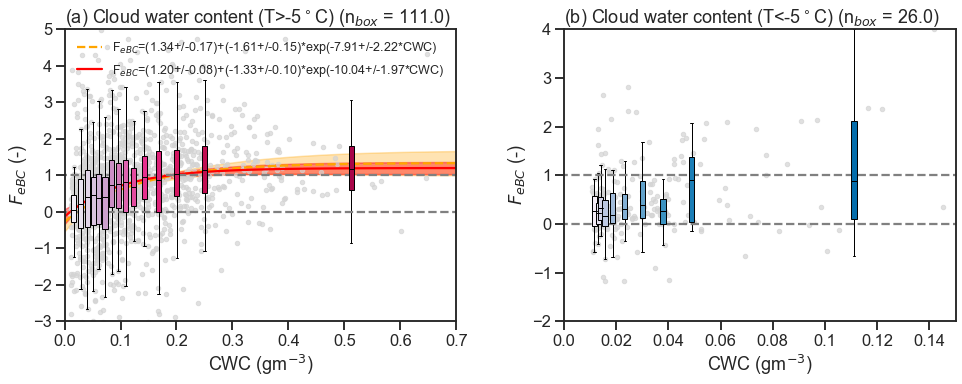

In [14]:
# Figure S5: The scavenged fraction of eBC binned by cloud water content for two different temperature regimes (Figure S5)

no_of_bins=15
px = np.linspace(0, 1, 100)

plt.figure(figsize=(14, 10))
ax=plt.subplot(2,2,1)
# first the raw data
plt.plot(df_CWC_T.CWC[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb>-5)],df_CWC_T.Ratio[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb>-5)],'.',color='lightgrey', alpha=0.7)
popt, pcov = curve_fit(func, df_CWC_T.CWC[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb>-5)].values,df_CWC_T.Ratio[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb>-5)].values, [0.7, -0.55,-5.29], maxfev=5000)
a1, b1, c1 = unc.correlated_values(popt, pcov)
dum2=(('F$_{eBC}$=('+'{:10.2f}'.format(a1) +') + ' + '('+'{:10.2f}'.format(b1) +') * exp(' +'{:10.2f}'.format(c1) +' * CWC)'))
# use unumpy.exp
py = a1 + b1* unp.exp(c1 * px)
nom = unp.nominal_values(py)
std = unp.std_devs(py)
plt.fill_between(px,nom  -2 * std, nom +2 * std, color='orange',alpha=0.3)
plt.plot(px,func(px,*popt),'--',color='orange',label=dum2.replace(" ",""))
# then the binned data
z_binned, bins = pd.qcut(df_CWC_T['CWC'][df_CWC_T.T_amb>-5],no_of_bins,retbins=True, precision=0)
grouped_N_all = df_CWC_T['Ratio'][df_CWC_T.T_amb>-5].groupby(z_binned)
palette = sns.color_palette('PuRd', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
z_binned.cat.rename_categories(mid)
bp1 = ax.boxplot([g for n,g in grouped_N_all], widths=0.009, positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=False)
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-0.1, 1, step=0.1))
ax.set_xticklabels(np.round(np.arange(-0.1, 1, step=0.1),2))
ax.set_xlim(0,0.7)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
nobs=df_CWC_T['Ratio'][df_CWC_T.T_amb>-5].groupby(z_binned).count()
popt, pcov = curve_fit(func, mid,df_CWC_T['Ratio'][df_CWC_T.T_amb>-5].groupby(z_binned).median().values, [0.7, -0.55,-5.29], maxfev=5000)
a2, b2, c2 = unc.correlated_values(popt, pcov)
dum1=(('F$_{eBC}$=('+'{:10.2f}'.format(a2) +') + ' + '('+'{:10.2f}'.format(b2) +') * exp(' +'{:10.2f}'.format(c2) +' * CWC)'))
# use unumpy.exp
py = a2 + b2* unp.exp(c2 * px)
nom = unp.nominal_values(py)
std = unp.std_devs(py)
plt.fill_between(px,nom  -2 * std, nom +2 * std, color='red',alpha=0.4)
plt.plot(px,func(px,*popt),'-',color='red',label=dum1.replace(" ","") )
plt.ylim(-3,5)
plt.legend(fontsize=12.5, frameon=False)
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('CWC (gm$^{-3}$)') 
plt.title('(a) Cloud water content (T>-5$^\circ$C) (n$_{box}$ = ' + str(grouped_N_all.count().mean().round()) + ')' , loc='left')
plt.plot([-1,7],[1,1],'--k',color='grey')
plt.plot([-1,7],[0,0],'--k',color='grey')

no_of_bins=10

ax=plt.subplot(2,2,2)
# first the raw data
plt.plot(df_CWC_T.CWC[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb<=-5)],df_CWC_T.Ratio[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb<=-5)],'.',color='lightgrey', alpha=0.7)
popt, pcov = curve_fit(func, df_CWC_T.CWC[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb<=-5)].values,df_CWC_T.Ratio[(df_CWC_T.Ratio>-5) & (df_CWC_T.Ratio<5) & (df_CWC_T.T_amb<=-5)].values, [0.7, -0.55,-5.29], maxfev=5000)
a1, b1, c1 = unc.correlated_values(popt, pcov)
dum2=(('F$_{eBC}$=('+'{:10.2f}'.format(a1) +') + ' + '('+'{:10.2f}'.format(b1) +') * exp(' +'{:10.2f}'.format(c1) +' * CWC)'))
# use unumpy.exp
py = a1 + b1* unp.exp(c1 * px)
nom = unp.nominal_values(py)
std = unp.std_devs(py)
# then the binned data
z_binned, bins = pd.qcut(df_CWC_T['CWC'][df_CWC_T.T_amb<=-5],no_of_bins,retbins=True, precision=0)
grouped_N_all = df_CWC_T['Ratio'][df_CWC_T.T_amb<=-5].groupby(z_binned)
palette = sns.color_palette('PuBu', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
z_binned.cat.rename_categories(mid)
bp1 = ax.boxplot([g for n,g in grouped_N_all], widths=0.002, positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=False)
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-0.1, 1.2, step=0.02))
ax.set_xticklabels(np.round(np.arange(-0.1, 1.2, step=0.02),2))
ax.set_xlim(0,0.7)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
nobs=df_CWC_T['Ratio'][df_CWC_T.T_amb<=-5].groupby(z_binned).count()
popt, pcov = curve_fit(func, mid,df_CWC_T['Ratio'][df_CWC_T.T_amb<=-5].groupby(z_binned).median().values, [0.7, -0.55,-5.29], maxfev=5000)
a2, b2, c2 = unc.correlated_values(popt, pcov)
py = a2 + b2* unp.exp(c2 * px)
nom = unp.nominal_values(py)
std = unp.std_devs(py)
plt.ylim(-2,4)
plt.ylabel('$F_{eBC}$ (-)')
plt.xlabel('CWC (gm$^{-3}$)') 
plt.xlim(0,0.15)
plt.title('(b) Cloud water content (T<-5$^\circ$C) (n$_{box}$ = ' + str(grouped_N_all.count().mean().round()) + ')', loc='left')
plt.plot([-1,7],[1,1],'--k',color='grey')
plt.plot([-1,7],[0,0],'--k',color='grey')
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


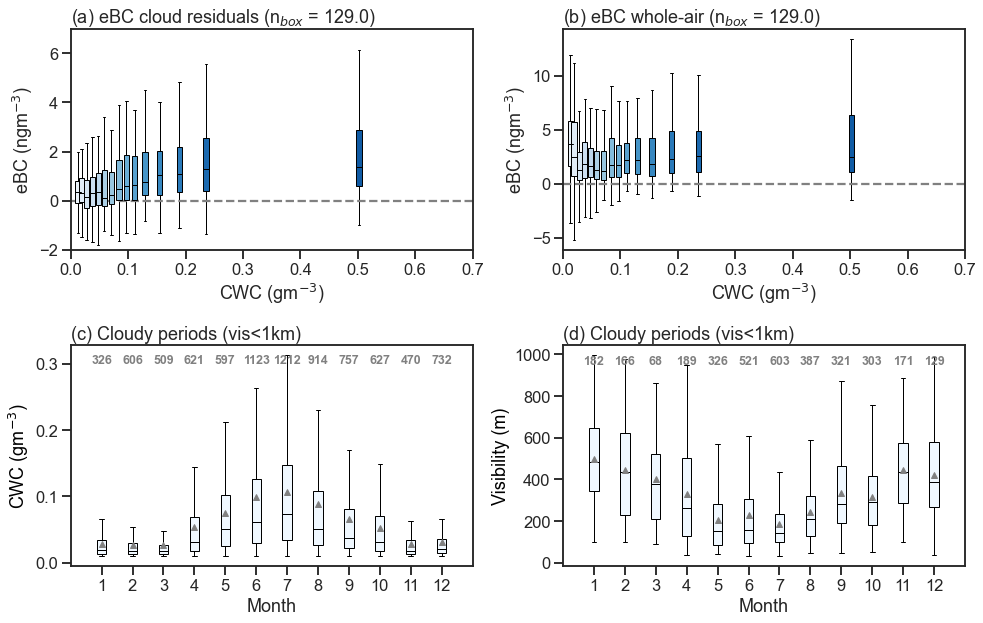

In [15]:
# Figure S6: eBC concentrations binned by cloud water content (CWC) and annual cycle of CWC and visibility
no_of_bins=15
dum1=abs_coeff_cloud[{'CWC','month'}]
dum1.dropna(inplace=True)
dum2=abs_coeff_cloud[{'vis','month'}]
dum2.dropna(inplace=True)

plt.figure(figsize=(14, 9))
ax=plt.subplot(2,2,1)
CWC_eBC_binned, bins = pd.qcut(df_ebC_2['CWC'],no_of_bins,retbins=True, precision=0)
grouped_CWC_eBC = df_ebC_2['eBC_CVI'].groupby(CWC_eBC_binned)
palette = sns.color_palette('Blues', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
CWC_eBC_binned.cat.rename_categories(mid)
bp1 = ax.boxplot([g for n,g in grouped_CWC_eBC], widths=0.009, positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=False,
                meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-0.1, 1, step=0.1))
ax.set_xticklabels(np.round(np.arange(-0.1, 1, step=0.1),2))

plt.xlabel('CWC (gm$^{-3}$)') 
plt.ylabel('eBC (ngm$^{-3}$)')
plt.title('(a) eBC cloud residuals (n$_{box}$ = ' + str(grouped_CWC_eBC.count().mean().round()) + ')' , loc='left')
plt.ylim(-2,7)
plt.plot([0,0.7],[0,0],'--k',color='grey')
ax.set_xlim(0,0.7)

ax=plt.subplot(2,2,2)
CWC_eBC_binned, bins = pd.qcut(df_ebC_3['CWC'],no_of_bins,retbins=True, precision=0)
grouped_CWC_eBC = df_ebC_3['eBC_tot'].groupby(CWC_eBC_binned)
palette = sns.color_palette('Blues', len(bins)+1)
mid = [(a + b) /2 for a,b in zip(bins[:-1], bins[1:])]
CWC_eBC_binned.cat.rename_categories(mid)
bp1 = ax.boxplot([g for n,g in grouped_CWC_eBC], widths=0.009, positions=mid, showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=False,
                meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
for i, box in enumerate(bp1['boxes']):
    box.set(facecolor=palette[i])
ax.set_xticks(np.arange(-0.1, 1, step=0.1))
ax.set_xticklabels(np.round(np.arange(-0.1, 1, step=0.1),2))

plt.xlabel('CWC (gm$^{-3}$)') 
plt.ylabel('eBC (ngm$^{-3}$)')
plt.title('(b) eBC whole-air (n$_{box}$ = ' + str(grouped_CWC_eBC.count().mean().round()) + ')' , loc='left')
#plt.ylim(-3,12)
plt.plot([0,0.7],[0,0],'--k',color='grey')
ax.set_xlim(0,0.7)

ax=plt.subplot(2,2,3)
grouped_data_1 = dum1.CWC.groupby(dum1['month'])
bp1 = ax.boxplot([g for n,g in grouped_data_1], widths=0.3, positions=np.linspace(1,12,12), showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=True,
                meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
plt.setp(bp1["boxes"], facecolor='aliceblue')
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(np.arange(1,13,1))
plt.xlim(0,13)
ax.set_ylabel('CWC (gm$^{-3}$)', color='black')
plt.title('(c) Cloudy periods (vis<1km)', loc='left')
nobs=dum1.CWC.groupby(dum1['month']).count()
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick]+1,
            0.3,
            nobs.iloc[tick],
            horizontalalignment='center',
            size='x-small',
            color='grey',
            weight='semibold')
plt.xlabel('Month')

ax=plt.subplot(2,2,4)
grouped_data_2 = dum2.vis.groupby(dum2['month'])
bp1 = ax.boxplot([g for n,g in grouped_data_2], widths=0.3, positions=np.linspace(1,12,12), showfliers=False,
                   patch_artist=True, medianprops={'color': 'k'}, showmeans=True,
                meanprops={'markerfacecolor': 'gray', 'markeredgecolor': 'gray'})
plt.setp(bp1["boxes"], facecolor='aliceblue')
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(np.arange(1,13,1))
plt.xlim(0,13)
ax.set_ylabel('Visibility (m)', color='black')
plt.title('(d) Cloudy periods (vis<1km)', loc='left')
nobs=dum2.vis.groupby(dum2['month']).count()
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick]+1,
            950,
            nobs.iloc[tick],
            horizontalalignment='center',
            size='x-small',
            color='grey',
            weight='semibold')
plt.xlabel('Month')
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


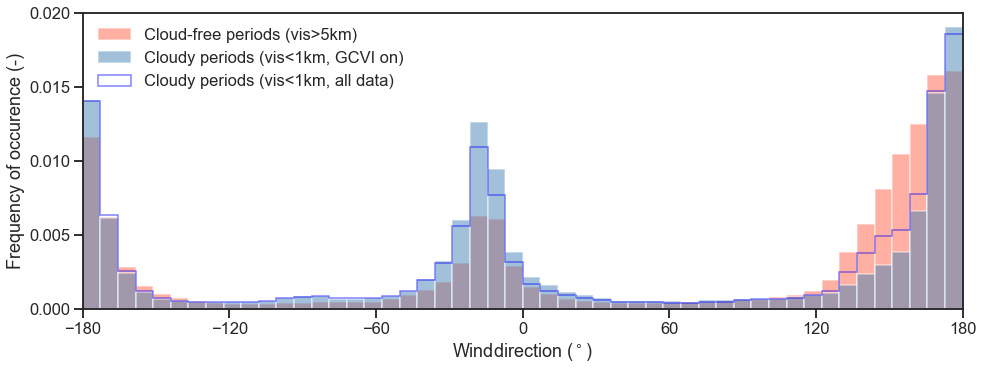

In [16]:
#  Figure S7: Normalised histogram of the occurrence of cloudy and cloud-free periods versus wind direction
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

plt.figure(figsize=(14, 15))
kwargs = dict(alpha=0.5, bins=50)
ax=plt.subplot(3,1,1)
plt.hist(MAAP.sdir[(MAAP.flag=='good') & (MAAP.CVI_status=='off')& (MAAP.visibility>5000)], **kwargs,density=True, color='tomato',label='Cloud-free periods (vis>5km)')
plt.hist(MAAP.sdir[(MAAP.flag=='good') & (MAAP.CVI_status=='on')& (MAAP.visibility<1000)], **kwargs,density=True, color='steelblue',label='Cloudy periods (vis<1km, GCVI on)')
plt.hist(MAAP.sdir[(MAAP.flag=='good') & (MAAP.visibility<1000)], **kwargs,density=True, histtype='step',color='blue',label='Cloudy periods (vis<1km, all data)')
plt.legend(frameon=False)
plt.ylabel('Frequency of occurence (-)')
plt.xlabel('Winddirection ($^\circ$)')
ax.set_xticks(range(-180,181,60))
plt.xlim(-180,180)
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launche

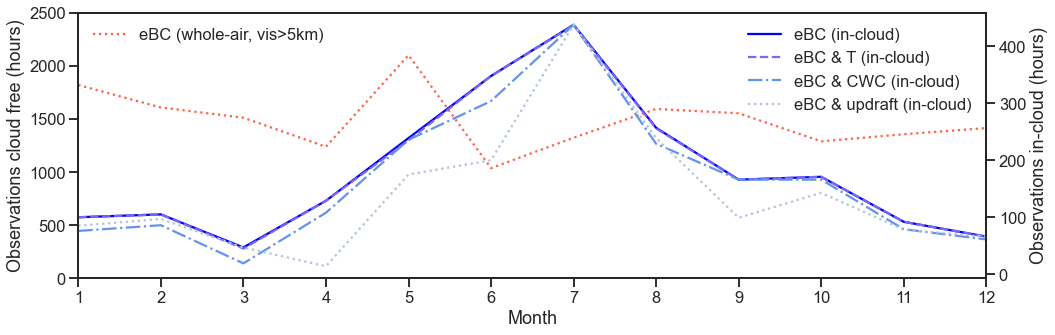

In [17]:
#  Figure S11: Available observations

df_dum_0=abs_coeff_cloud[{'eBC_tot','month'}]
df_dum_0.dropna(inplace=True)
df_dum_1=abs_coeff_cloud[{'eBC_CVI','month'}]
df_dum_1.dropna(inplace=True)
df_dum_2=abs_coeff_cloud[{'eBC_CVI','eBC_tot','T_amb','month'}]
df_dum_2.dropna(inplace=True)
df_dum_3=abs_coeff_cloud[{'eBC_CVI','eBC_tot','CWC','month'}]
df_dum_3.dropna(inplace=True)
df_dum_4=abs_coeff_cloud[{'eBC_CVI','eBC_tot','z','month'}]
df_dum_4.dropna(inplace=True)

sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), sharex=True)
BC_tot_nop=abs_coeff_nocloud['eBC_tot'].groupby(abs_coeff_nocloud['month']).count()
BC_cvi_0_nop=df_dum_0[{'eBC_tot'}].groupby(df_dum_0['month']).count()
BC_cvi_1_nop=df_dum_1[{'eBC_CVI'}].groupby(df_dum_1['month']).count()
BC_cvi_2_nop=df_dum_2[{'eBC_CVI'}].groupby(df_dum_2['month']).count()
BC_cvi_3_nop=df_dum_3[{'eBC_CVI'}].groupby(df_dum_3['month']).count()
BC_cvi_4_nop=df_dum_4[{'eBC_CVI'}].groupby(df_dum_4['month']).count()
plt.plot(BC_tot_nop,':',color='tomato',label='eBC (whole-air, vis>5km)')
plt.ylabel('Observations cloud free (hours)')
plt.ylim(0,2500)
plt.legend(loc='upper left',frameon=False)
ax2 = ax.twinx()
plt.plot(BC_cvi_1_nop,'-',color='blue',label='eBC (in-cloud)')
plt.plot(BC_cvi_2_nop,'--',color='mediumslateblue',label='eBC & T (in-cloud)')
plt.plot(BC_cvi_3_nop,'-.',color='cornflowerblue',label='eBC & CWC (in-cloud)')
plt.plot(BC_cvi_4_nop,':',color='lightsteelblue',label='eBC & updraft (in-cloud)')
plt.legend(frameon=False,loc=1)
plt.ylabel('Observations in-cloud (hours)')
ax.set_xticks(range(1, 13))
ax.set_xlabel('Month')
plt.xlim(1,12)
plt.tight_layout()